In [1]:
# Env name and device
env_name = 'maze2d-open-v1'
horizon = 128
device = 0

# !export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/cspark/.mujoco/mujoco210/bin
# # Somehow the notebook can't detect necessary env variables we manually set env variabel
# import os
# os.environ['LD_LIBRARY_PATH'] = f"{os.getenv('LD_LIBRARY_PATH')}:/usr/lib/nvidia:/home/cspark/.mujoco/mujoco210/bin"

In [2]:
# get dataset
from diffuser.datasets import GoalDataset, UnconditionedDataset

dataset = GoalDataset(env=env_name, termination_penalty=None, 
                      horizon=horizon,
                      normalizer='LimitsNormalizer', 
                      preprocess_fns=[],
                      use_padding=False,
                      max_path_length=40000
                      )

pybullet build time: Nov 28 2023 23:51:11
load datafile: 100%|██████████| 8/8 [00:00<00:00, 18.53it/s]


[ datasets/buffer ] Finalized replay buffer | 10000 episodes
[ datasets/buffer ] Fields:
    actions: (10000, 40000, 2)
    info/goal: (10000, 40000, 2)
    info/qpos: (10000, 40000, 2)
    info/qvel: (10000, 40000, 2)
    observations: (10000, 40000, 4)
    rewards: (10000, 40000, 1)
    terminals: (10000, 40000, 1)
    timeouts: (10000, 40000, 1)
    next_observations: (10000, 40000, 4)
    normed_observations: (10000, 40000, 4)
    normed_actions: (10000, 40000, 2)


In [3]:
# Get renderer
from diffuser.utils.rendering import Maze2dRenderer

renderer = Maze2dRenderer(env_name)

/home/cspark/anaconda3/envs/diffuser/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/cspark/anaconda3/envs/diffuser/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/cspark/anaconda3/envs/diffuser/lib/python3.8/site-packages/matplotlib/backend_bases.py:60: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(PILLOW_VERSION) >= "3.4":
/home/cspark/anaconda3/envs/diffuser/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [4]:
# Get model
from diffuser.models import TemporalUnet

observation_dim = dataset.observation_dim
action_dim = dataset.action_dim

model = TemporalUnet(horizon=horizon,
                     transition_dim=observation_dim + action_dim,
                     cond_dim=observation_dim,
                     dim_mults=(1, 4, 8),
                     )
model.to(device=device);

[ models/temporal ] Channel dimensions: [(6, 32), (32, 128), (128, 256)]
[(6, 32), (32, 128), (128, 256)]


In [5]:
# Get diffusion model
from diffuser.models import GaussianDiffusion

diffusion_model = GaussianDiffusion(
    model=model,
    horizon=horizon,
    observation_dim=observation_dim,
    action_dim=action_dim,
    n_timesteps=64,
    loss_type='l2',
    clip_denoised=True,
    predict_epsilon=False,
    action_weight=1,
    loss_weights=None,
    loss_discount=1,
)
diffusion_model.to(device=device);

In [6]:
# Load trained model
import torch

modelpath = f"../logs/maze2d-open-v2/w_conditon_H128_long_intersection_length/state_196000.pt"
diffusion_model.load_state_dict(torch.load(modelpath)['ema'])
diffusion_model.eval();

In [7]:
# get condition
import einops
from diffuser.utils import to_device, apply_dict

n_samples = 5

dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=1, num_workers=0, shuffle=True, pin_memory=True
        )

In [8]:
datas = []

for i in range(2):
    data = next(iter(dataloader))
    
    if i == 0:
        while 0 < data.conditions[0][0, 0]:
            data = next(iter(dataloader))
        
    else:
        while 0 > data.conditions[0][0, 0]:
            data = next(iter(dataloader))
    datas.append(data)



In [9]:
# conditions = to_device({0:data.conditions[0]})
# data = next(iter(dataloader))
# conditions = to_device(data.conditions)
# conditions = apply_dict(
#                 einops.repeat,
#                 conditions,
#                 'b d -> (repeat b) d', repeat=n_samples,
#             )
# conditions = {}

conditions_lst = []

for data in datas:
    conditions = to_device(data.conditions)
    conditions_lst.append(conditions)

conditions = conditions_lst[0]
for condition_element in conditions_lst[1:]:
    for k, v in condition_element.items():
        conditions[k] = torch.cat([conditions[k], v], dim=0)

conditions[0] = torch.cat([conditions[0], conditions[0]], dim=0)
keys_lst = list(conditions.keys())
conditions[keys_lst[-1]] = torch.cat([conditions[keys_lst[-1]], conditions[keys_lst[-1]].flip(dims=(0,))], dim=0)

conditions = apply_dict(
                einops.repeat,
                conditions,
                'b d -> (b copy) d', copy=n_samples,
            )

In [10]:
conditions

{0: tensor([[-0.7050, -0.7823, -0.0440, -0.3690],
         [-0.7050, -0.7823, -0.0440, -0.3690],
         [-0.7050, -0.7823, -0.0440, -0.3690],
         [-0.7050, -0.7823, -0.0440, -0.3690],
         [-0.7050, -0.7823, -0.0440, -0.3690],
         [ 0.8255, -0.7858,  0.0022, -0.4936],
         [ 0.8255, -0.7858,  0.0022, -0.4936],
         [ 0.8255, -0.7858,  0.0022, -0.4936],
         [ 0.8255, -0.7858,  0.0022, -0.4936],
         [ 0.8255, -0.7858,  0.0022, -0.4936],
         [-0.7050, -0.7823, -0.0440, -0.3690],
         [-0.7050, -0.7823, -0.0440, -0.3690],
         [-0.7050, -0.7823, -0.0440, -0.3690],
         [-0.7050, -0.7823, -0.0440, -0.3690],
         [-0.7050, -0.7823, -0.0440, -0.3690],
         [ 0.8255, -0.7858,  0.0022, -0.4936],
         [ 0.8255, -0.7858,  0.0022, -0.4936],
         [ 0.8255, -0.7858,  0.0022, -0.4936],
         [ 0.8255, -0.7858,  0.0022, -0.4936],
         [ 0.8255, -0.7858,  0.0022, -0.4936]], device='cuda:0'),
 127: tensor([[ 0.4613,  0.7110,  0.59

In [11]:
# sample trajectory 
import numpy as np
from diffuser.utils import to_np

## [ n_samples x horizon x (action_dim + observation_dim) ]
samples = diffusion_model.conditional_sample(conditions, verbose=False, batch_size=n_samples*20)
samples = to_np(samples)

## [ n_samples x horizon x observation_dim ]
normed_observations = samples[:, :, action_dim:]

# [ 1 x 1 x observation_dim ]
# normed_conditions = to_np(conditions[0])[:,None]

# from diffusion.datasets.preprocessing import blocks_cumsum_quat
# observations = conditions + blocks_cumsum_quat(deltas)
# observations = conditions + deltas.cumsum(axis=1)

## [ n_samples x (horizon + 1) x observation_dim ]
normed_observations = np.concatenate([
    # normed_conditions,
    normed_observations
], axis=1)

## [ n_samples x (horizon + 1) x observation_dim ]
observations = dataset.normalizer.unnormalize(normed_observations, 'observations')

Saved 20 samples to: dummy.png


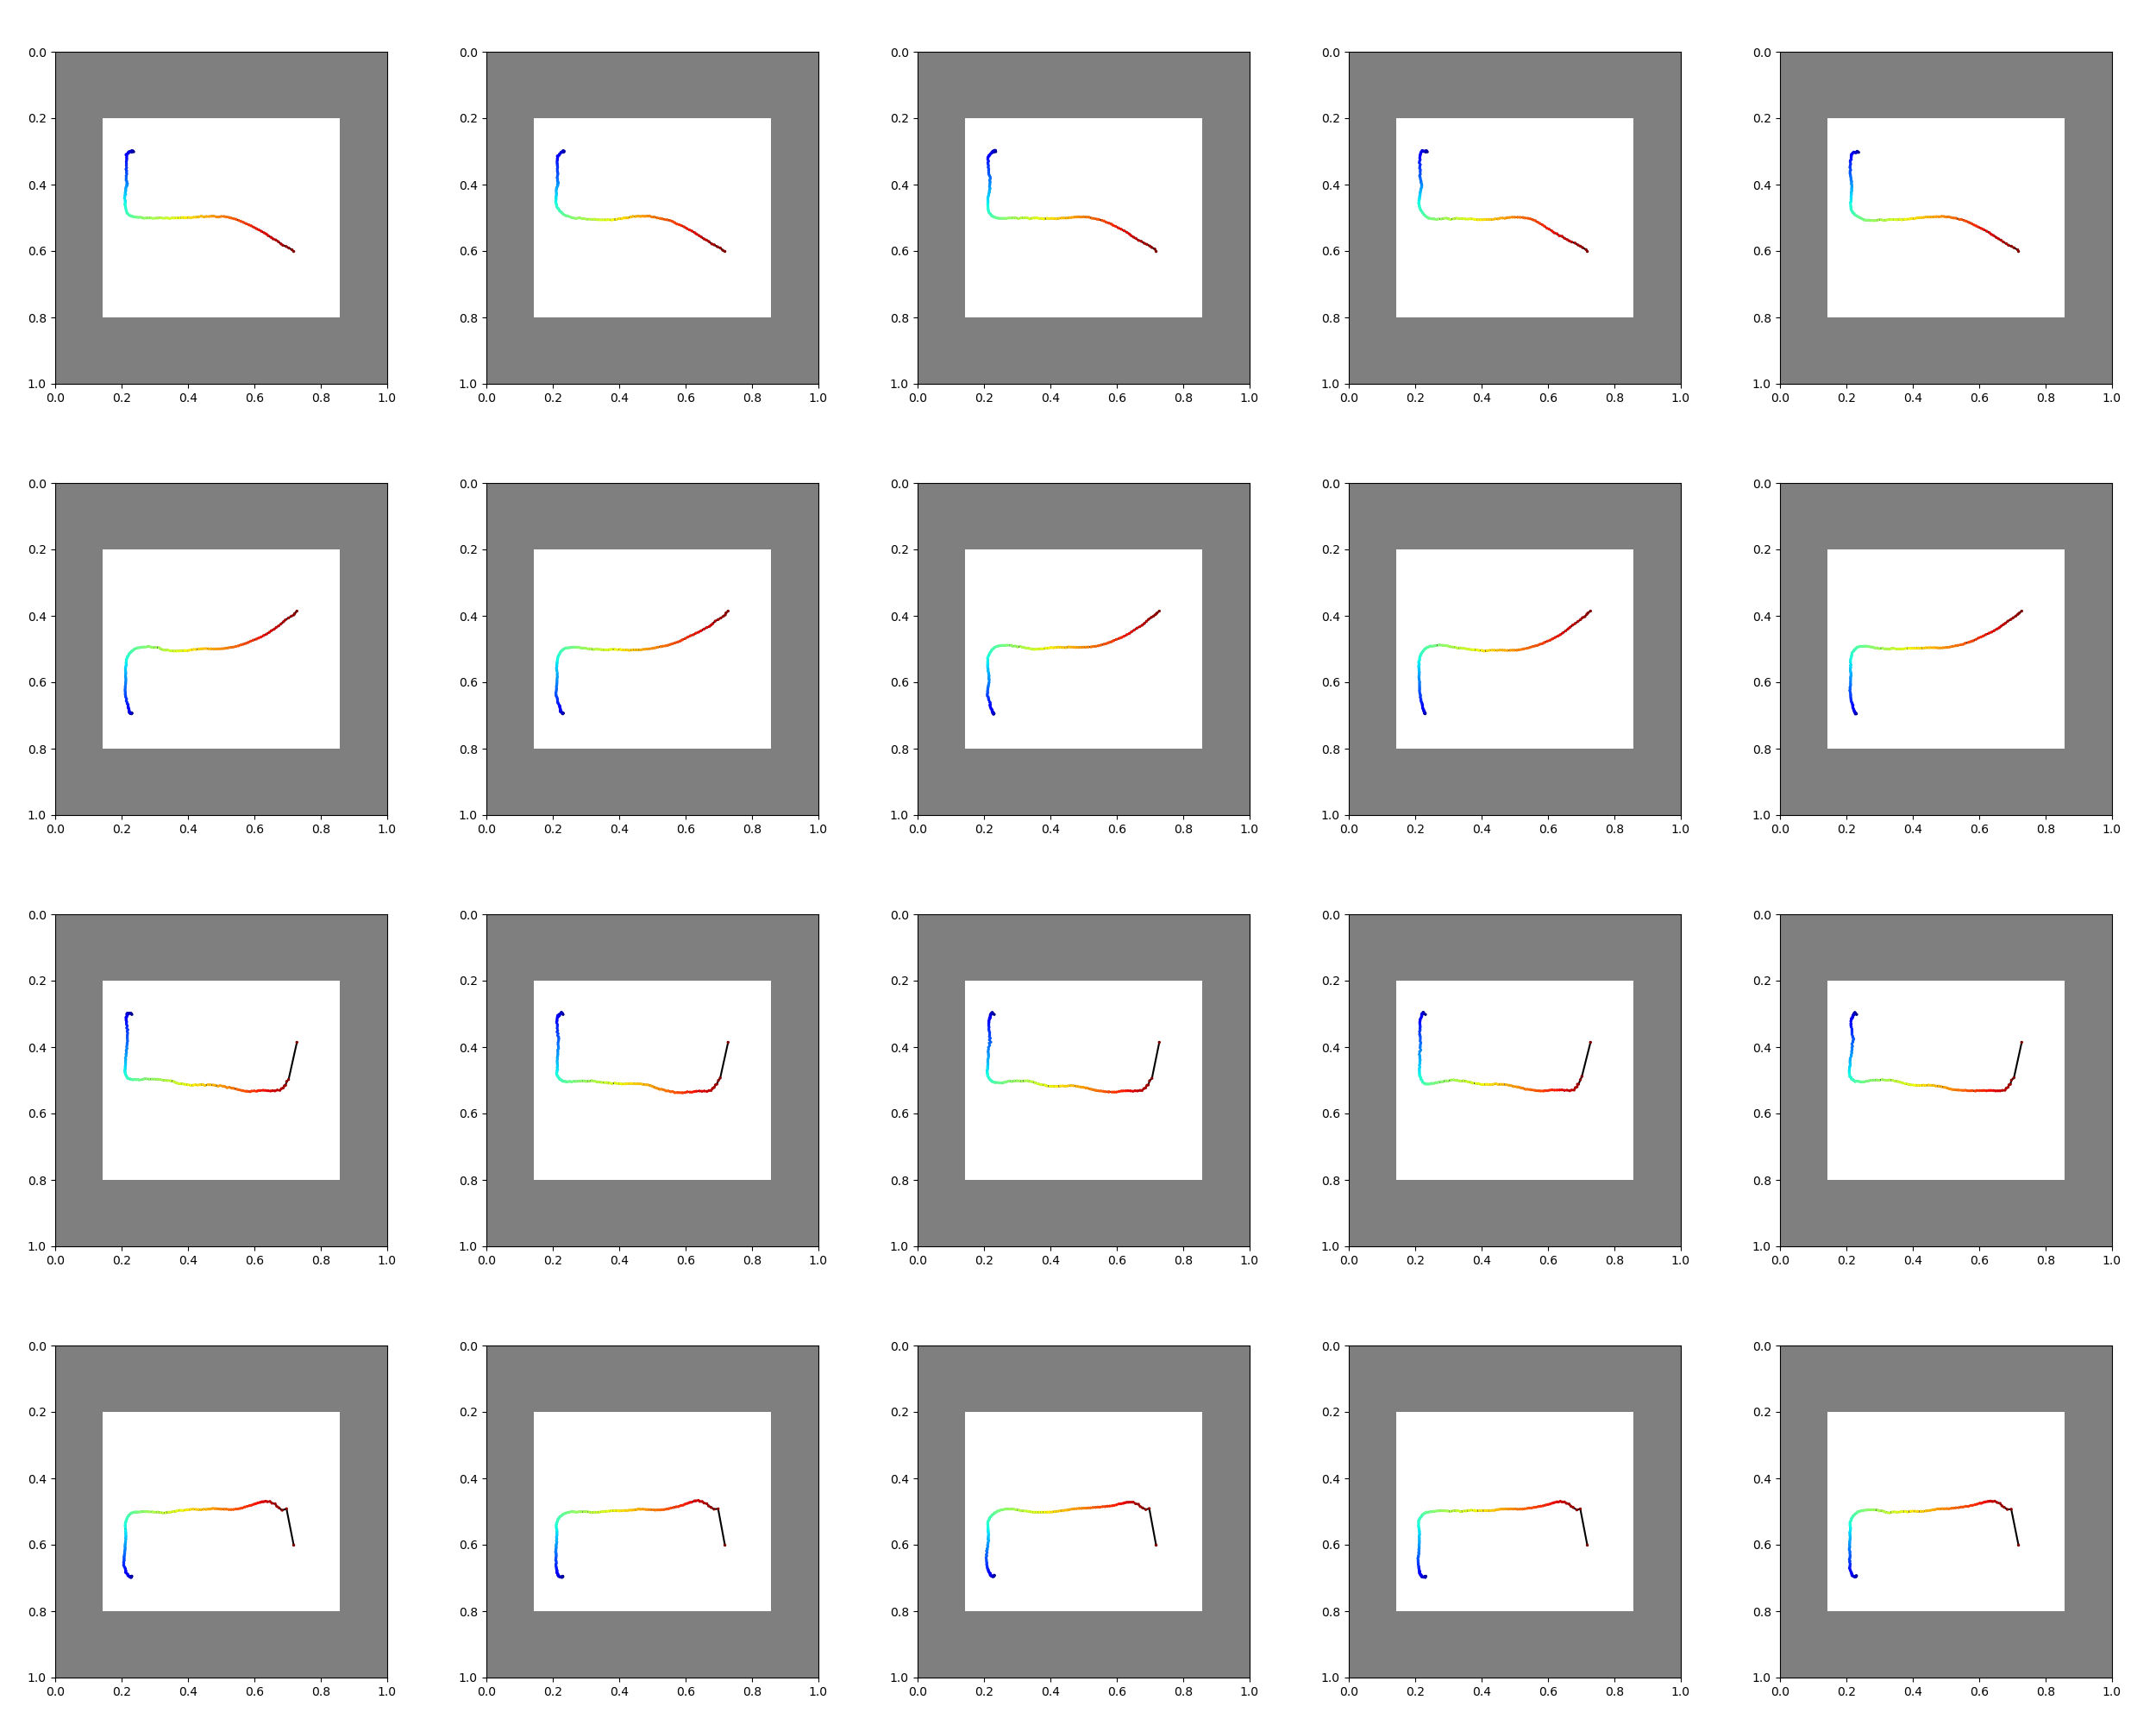

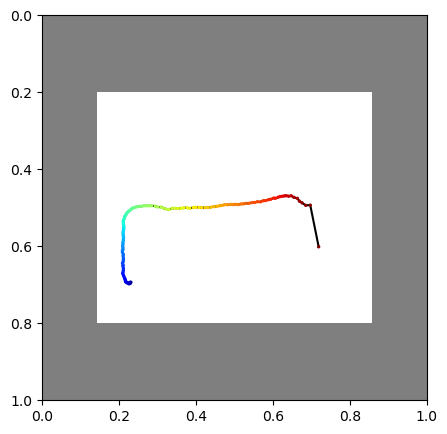

In [12]:
renderer.composite(f"dummy.png", observations, ncol=n_samples)

In [ ]:
import os
print(os.getenv('LD_LIBRARY_PATH'))